In [196]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [197]:
ust = ["US1MT=RR", "US3MT=RR", "US6MT=RR", "US1YT=RR", "US2YT=RR", "US5YT=RR", "US10YT=RR", "US30YT=RR"]
data_ust = pd.read_csv('UST_working.csv', index_col=0)
data_ust_diff = data_ust.diff()
data_ust_diff.index = pd.to_datetime(data_ust_diff.index)
data_ust_diff = data_ust_diff.resample('W').last()

In [198]:
params = [(['US3MT', ], ['US6MT', ]), (['US3MT', 'US6MT' ], ['US1YT', ]), (['US3MT', 'US6MT', 'US1YT' ], ['US2YT', ]), (['US3MT', 'US6MT', 'US1YT', 'US2YT' ], ['US5YT', ])]

for X_lab, y_lab in params:
    print(f"target: {y_lab[0]}")
    M = data_ust_diff.loc[:, X_lab + y_lab].dropna()
    X, y = M.loc[:, X_lab], M.loc[:, y_lab]

    lr = LinearRegression().fit(X, y)
    print(f"score: {lr.score(X, y)}")
    print(f"coef: {lr.coef_}\n")

target: US6MT
score: 0.6172988074817097
coef: [[0.65146319]]

target: US1YT
score: 0.591218392257503
coef: [[-0.06636882  0.86875847]]

target: US2YT
score: 0.7235663389481182
coef: [[-0.11601637 -0.50438738  1.81483565]]

target: US5YT
score: 0.534605495505662
coef: [[-0.14699461  0.43839235 -0.03542372  0.60981359]]



<AxesSubplot:xlabel='date'>

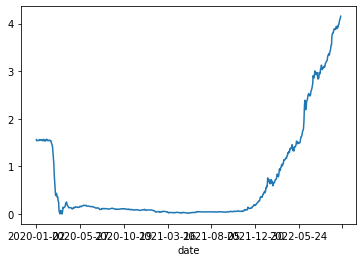

In [199]:
data_ust.loc["2020-01-01":].US6MT.plot()

In [227]:
# get the mean hikes during intervals of rate hikes
rate_hike_data = pd.concat([data_ust_diff.loc["2004-01-01":"2008-01-01", :],
                            data_ust_diff.loc["2016-01-01":"2019-01-01", :],
                            data_ust_diff.loc["2022-01-01":, :]], axis=0)
mu = rate_hike_data.mean()
cv = data_ust_diff.iloc[-52 * 5:].cov() # 5y recent covariance
res = []

for i in range(5000):
    if (i+1) % 100 == 0:
        print(i+1)
        # break
    rng = np.random.default_rng()

    # construct yield curve movement based on provided mu (mean hike) and covariance
    sim_p1 = rng.multivariate_normal(2.5 * mu, cv, 45)
    sim_p2 = rng.multivariate_normal(0.25 * mu, cv, 75)
    sim_p3 = rng.multivariate_normal(-0.1 * mu, cv, 45)
    sim_tot = pd.DataFrame(np.vstack([sim_p1, sim_p2, sim_p3]), columns=data_ust_diff.columns)
    sim_tot.index = pd.date_range(data_ust_diff.index[-1]+pd.DateOffset(7), periods=len(sim_tot), freq='W')
    sim_fut = (data_ust.iloc[-1] + sim_tot.cumsum())
    res.append(sim_fut)

US1MT     0.011111
US3MT     0.005470
US6MT     0.003662
US1YT     0.002486
US2YT     0.001745
US5YT     0.003492
US10YT    0.001580
US30YT   -0.001049
dtype: float64
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


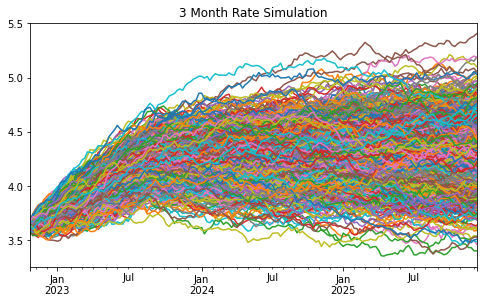

In [228]:
sim_by_col = [pd.concat([df.loc[:, col] for df in res], axis=1) for col in data_ust.columns]
sim_by_col[1].iloc[:, :1000].plot(figsize=(8, 4.5), title='3 Month Rate Simulation')
plt.gca().get_legend().remove()

In [229]:
q_tenor = {}
for i, tenor in enumerate(data_ust_diff.columns):
    q_tenor[tenor] = sim_by_col[i].quantile(q=[0.1, 0.25, 0.5, 0.75, 0.9], axis=1).T #.to_csv(f'./rates_sim_out/{tenor}.csv')

In [230]:
sim_q = {}
for q in [0.1, 0.25, 0.5, 0.75, 0.9]:
    df = pd.concat([q_tenor[tenor].loc[:, q] for i, tenor in enumerate(data_ust_diff.columns)], axis=1)
    df.columns = data_ust_diff.columns
    sim_q[int(q * 100)] = df
    sim_q[int(q * 100)].to_csv(f"./rates_sim_out/Q_{int(q*100):02d}.csv")

<AxesSubplot:>

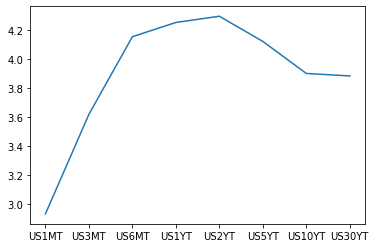

In [231]:
data_ust.iloc[-1].plot()

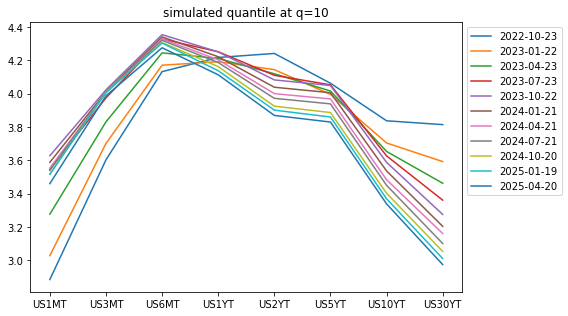

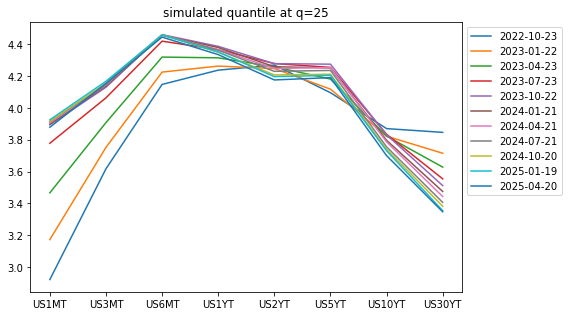

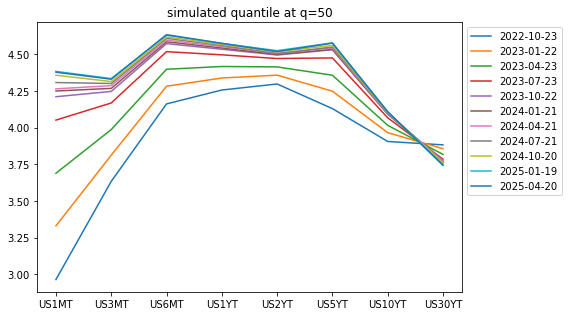

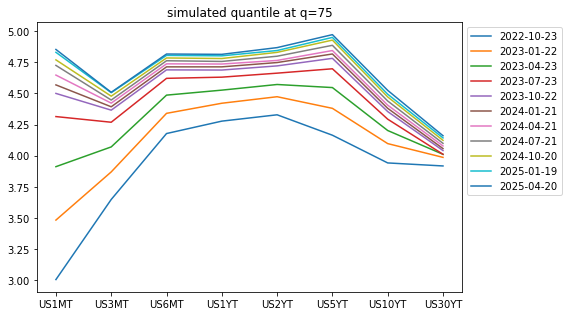

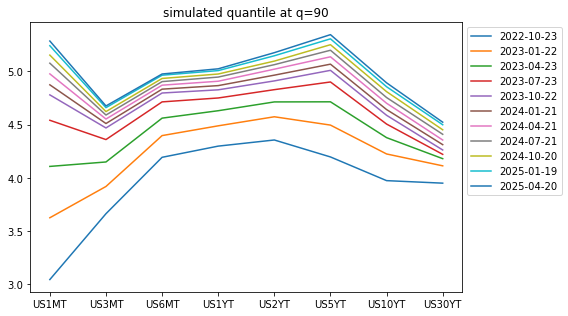

In [232]:
for q in [10, 25, 50, 75, 90]:
    tmp = sim_q[q].iloc[[0, 13, 26, 39, 52, 65, 78, 91, 104, 117, 130], :]
    tmp.index = tmp.index.map(lambda x: x._date_repr)
    tmp.T.plot(title=f"simulated quantile at {q=}", figsize=(8, 4.5))
    plt.gca().legend(bbox_to_anchor=(1., 1.), loc='upper left')
    plt.tight_layout()

In [242]:
from queue import PriorityQueue

res_q = {}
tenor_mapper = {13: 'US3MT', 26: 'US6MT', 52: 'US1YT', 104: 'US2YT'}
q_list = [10, 25, 50, 75, 90]
p_list = [13, 26, 52, 104]
top_n = 100

for q in q_list:
    fron = PriorityQueue()
    fron.put((0, ('2022-10-23', [])))
    data = sim_q[q]
    res, seen = [], []

    print(f'** START Q={q}')
    while fron.queue:
        prio, (dt_from, path_taken) = fron.get()
        data_sliced = data.loc[dt_from:, :]
        yld = -prio
        done = False

        for p in p_list:
            # print(f'** START P={p}')
            if p > len(data_sliced):
                if sum(path_taken) < 0.7 * len(data):
                    continue

                if path_taken not in seen:
                    res.append((yld, np.round(yld / sum(path_taken) * len(data), 4), path_taken, sum(path_taken)))
                    seen.append(path_taken)
                    if top_n > 10:
                        if len(res) % 10 == 0: print(f'**** FOUND RES #{len(res)} ON {dt_from}')

                if len(res) >= top_n:
                    done = True
                    break
                continue

            yld_crv = data_sliced.iloc[p]
            dt_new = yld_crv.name
            yld_new = yld_crv.loc[tenor_mapper[p]]
            fron.put((-np.round(yld + yld_new / 52 * p, 4), (dt_new._date_repr, path_taken + [p, ])))
            # print(yld_new)
            # print(fron.queue)

        if done:
            print(f'** DONE Q={q}')
            break

    res_q[q] = res

** START Q=10
**** FOUND RES #10 ON 2025-10-19
**** FOUND RES #20 ON 2025-07-20
**** FOUND RES #30 ON 2025-10-19
**** FOUND RES #40 ON 2025-07-20
**** FOUND RES #50 ON 2025-10-19
**** FOUND RES #60 ON 2025-10-19
**** FOUND RES #70 ON 2025-07-20
**** FOUND RES #80 ON 2025-04-20
**** FOUND RES #90 ON 2025-10-19
**** FOUND RES #100 ON 2025-01-19
** DONE Q=10
** START Q=25
**** FOUND RES #10 ON 2025-10-19
**** FOUND RES #20 ON 2025-07-20
**** FOUND RES #30 ON 2025-10-19
**** FOUND RES #40 ON 2025-07-20
**** FOUND RES #50 ON 2025-10-19
**** FOUND RES #60 ON 2025-10-19
**** FOUND RES #70 ON 2025-07-20
**** FOUND RES #80 ON 2025-04-20
**** FOUND RES #90 ON 2025-10-19
**** FOUND RES #100 ON 2025-01-19
** DONE Q=25
** START Q=50
**** FOUND RES #10 ON 2025-10-19
**** FOUND RES #20 ON 2025-07-20
**** FOUND RES #30 ON 2025-10-19
**** FOUND RES #40 ON 2025-07-20
**** FOUND RES #50 ON 2025-10-19
**** FOUND RES #60 ON 2025-10-19
**** FOUND RES #70 ON 2025-07-20
**** FOUND RES #80 ON 2025-04-20
**** F

In [243]:
for q in q_list:
    print(f'{q=}')
    for _, norm_yld, path_taken, _ in sorted(res_q[q], key=lambda x: -x[1])[:10]:
        print(f"NORMALIZED YIELD={norm_yld}, PATH TAKEN={path_taken}")

q=10
NORMALIZED YIELD=13.5851, PATH TAKEN=[52, 26, 26, 26]
NORMALIZED YIELD=13.5606, PATH TAKEN=[52, 26, 26, 26, 26]
NORMALIZED YIELD=13.4949, PATH TAKEN=[52, 26, 26, 13, 26]
NORMALIZED YIELD=13.4939, PATH TAKEN=[52, 26, 13, 26, 26]
NORMALIZED YIELD=13.4932, PATH TAKEN=[52, 26, 26, 13]
NORMALIZED YIELD=13.4919, PATH TAKEN=[52, 26, 13, 26]
NORMALIZED YIELD=13.4913, PATH TAKEN=[52, 26, 26, 26, 13]
NORMALIZED YIELD=13.4896, PATH TAKEN=[52, 13, 26, 26, 26]
NORMALIZED YIELD=13.4867, PATH TAKEN=[52, 13, 26, 26]
NORMALIZED YIELD=13.4135, PATH TAKEN=[52, 26, 26, 13, 13, 26]
q=25
NORMALIZED YIELD=14.0415, PATH TAKEN=[52, 26, 26, 26]
NORMALIZED YIELD=14.0344, PATH TAKEN=[52, 26, 26, 26, 26]
NORMALIZED YIELD=13.9578, PATH TAKEN=[52, 26, 26, 26, 13]
NORMALIZED YIELD=13.9577, PATH TAKEN=[52, 26, 26, 13, 26]
NORMALIZED YIELD=13.9514, PATH TAKEN=[52, 26, 13, 26, 26]
NORMALIZED YIELD=13.9497, PATH TAKEN=[52, 13, 26, 26, 26]
NORMALIZED YIELD=13.9377, PATH TAKEN=[52, 26, 26, 13]
NORMALIZED YIELD=13.9299

`q` denotes the average percentile in terms of the rate curve at a certain date.
For `q=10`, a low 10-pctile rate hike environment, the optimal action indicated by `[52, 26, 26, 26]` would mean it is best to buy 1y (52-wks), then buy 6m (26-wks), 6m, 6m to capture the most yield.